In [3]:
import pandas as pd

df = pd.read_csv(r"C:\Users\vijay\Downloads\TG-SPDCL_consumption_detail_domestic_11_2025.csv")

print("Shape:", df.shape)
display(df.head())



Shape: (15746, 11)


,circle,division,subdivision,section,area,catdesc,catcode,totservices,billdservices,units,load
0,BANJARA HILLS,BANJARA HILLS,JUBILEE HILLS,MADHAPUR,"ARUNDHOYA,IMAGE GARDEN, HARIZA",DOMESTIC,1,41,38.0,15982.0,541.26
1,BANJARA HILLS,BANJARA HILLS,JUBILEE HILLS,MADHAPUR,ARUNODAYA COLONY,DOMESTIC,1,589,585.0,118230.0,2256.60
2,BANJARA HILLS,BANJARA HILLS,JUBILEE HILLS,MADHAPUR,COD TO MADHAPUR PS SIDE GRC,DOMESTIC,1,33,23.0,10009.0,247.00
3,BANJARA HILLS,BANJARA HILLS,JUBILEE HILLS,MADHAPUR,"CYBER TOWER AREA,PATRIKANAGAR",DOMESTIC,1,41,39.0,50108.0,756.00
4,BANJARA HILLS,BANJARA HILLS,JUBILEE HILLS,MADHAPUR,"IMAGE GARDEN LANE,JAIHIND ENCL",DOMESTIC,1,652,597.0,140135.0,2882.12


In [5]:
# Fixed target
TARGET = "catdesc"
print("Using TARGET =", TARGET)

# Identify numeric and categorical columns
num_cols = ['totservices', 'billdservices', 'units', 'load']
cat_cols = ['circle', 'division', 'subdivision', 'section', 'area', 'catdesc', 'catcode']

print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Using TARGET = catdesc
Numeric Columns: ['totservices', 'billdservices', 'units', 'load']
Categorical Columns: ['circle', 'division', 'subdivision', 'section', 'area', 'catdesc', 'catcode']


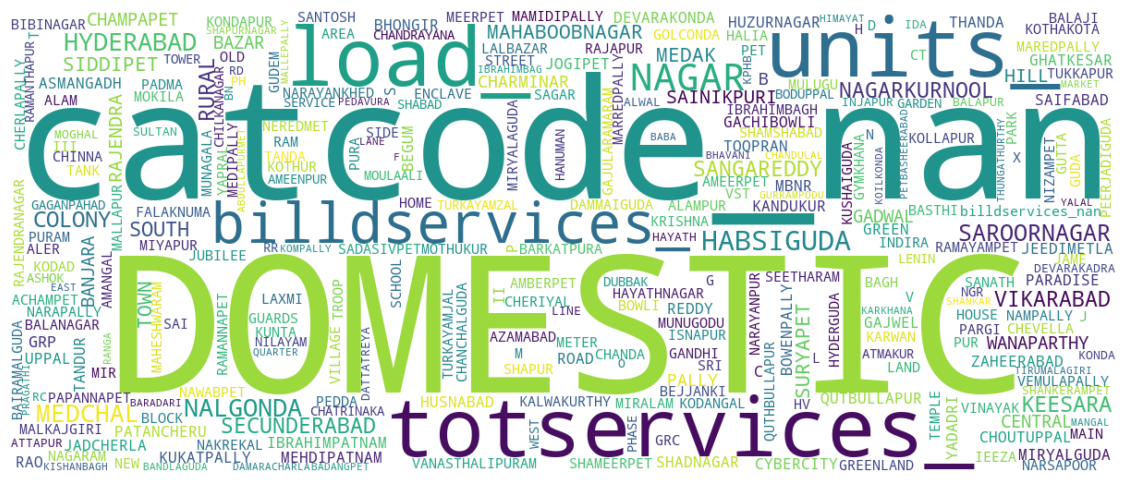

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Build text corpus from ALL columns
def build_full_corpus(df):
    corpus_parts = []

    for col in df.columns:
        series = df[col].dropna().astype(str)

        # If numeric, convert into binned text words (makes more meaningful cloud)
        if pd.api.types.is_numeric_dtype(df[col]):
            try:
                bins = pd.qcut(df[col], q=5, duplicates='drop').astype(str)
                corpus_parts.append(" ".join([f"{col}_{b}" for b in bins]))
            except:
                corpus_parts.append(" ".join(series))
        else:
            corpus_parts.append(" ".join(series))

    corpus = " ".join(corpus_parts)
    return corpus


# Create full corpus
corpus = build_full_corpus(df)

# Generate Word Cloud
wc = WordCloud(
    width=1200,
    height=500,
    background_color="white",
    collocations=False,
    stopwords=set(STOPWORDS),
    max_words=300
).generate(corpus)

plt.figure(figsize=(15,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


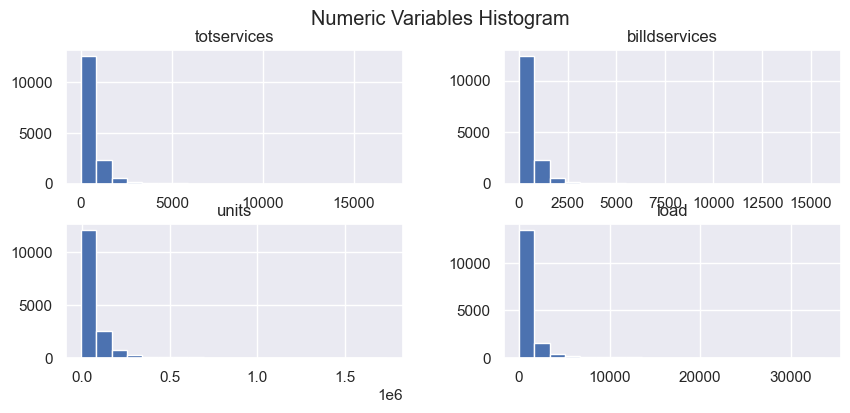

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df[num_cols].hist(bins=20, figsize=(10,4))
plt.suptitle("Numeric Variables Histogram")
plt.show()


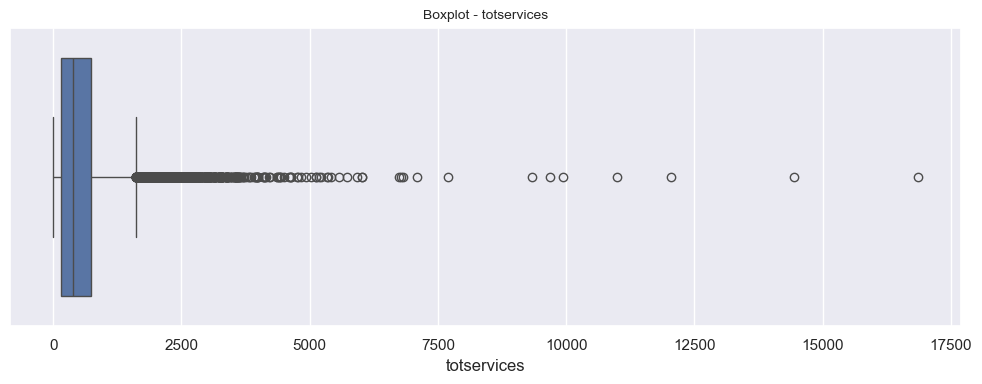

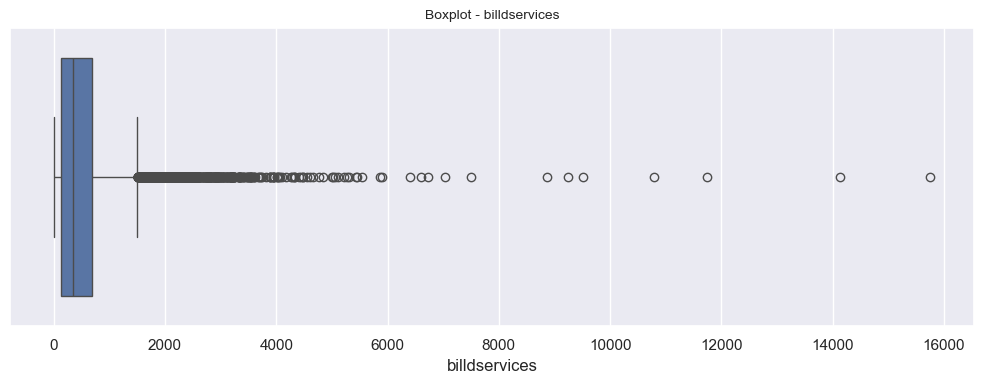

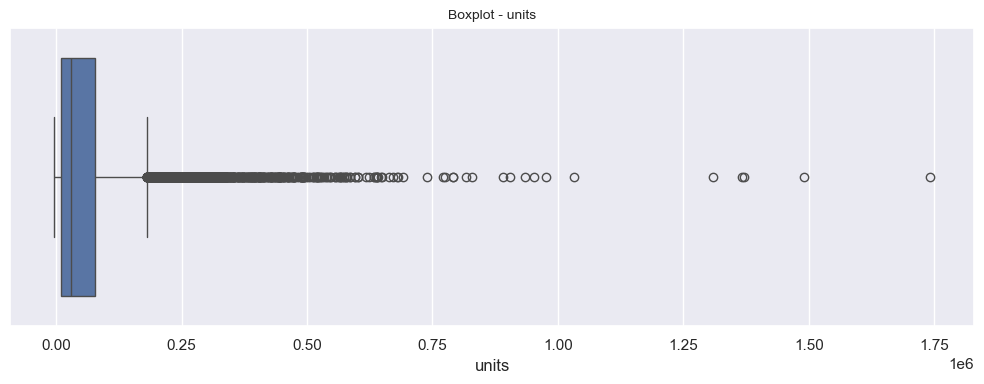

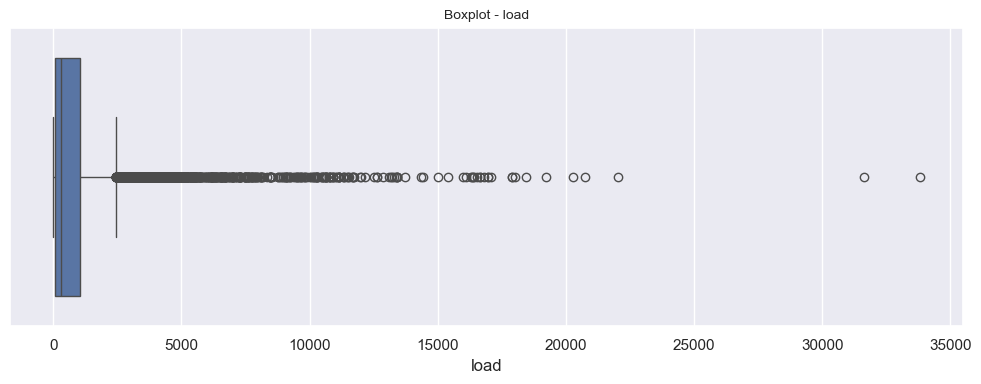

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

for c in num_cols:
    plt.figure(figsize=(10,4))   # width=5, height=2 (small & neat)
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot - {c}", fontsize=10)
    plt.tight_layout()
    plt.show()


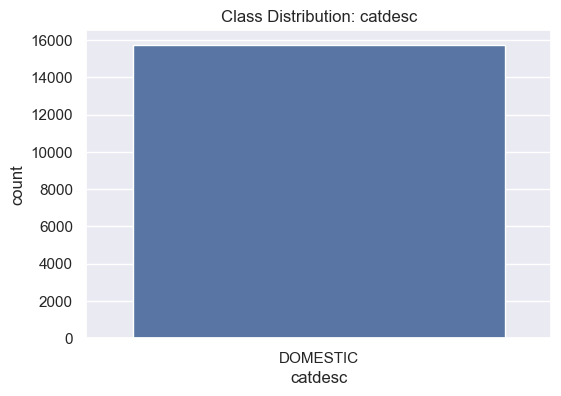

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=df[TARGET])
plt.title("Class Distribution: catdesc")
plt.show()


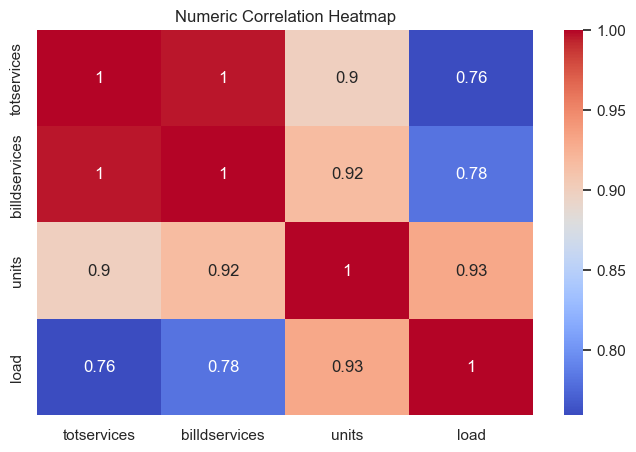

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Numeric Correlation Heatmap")
plt.show()


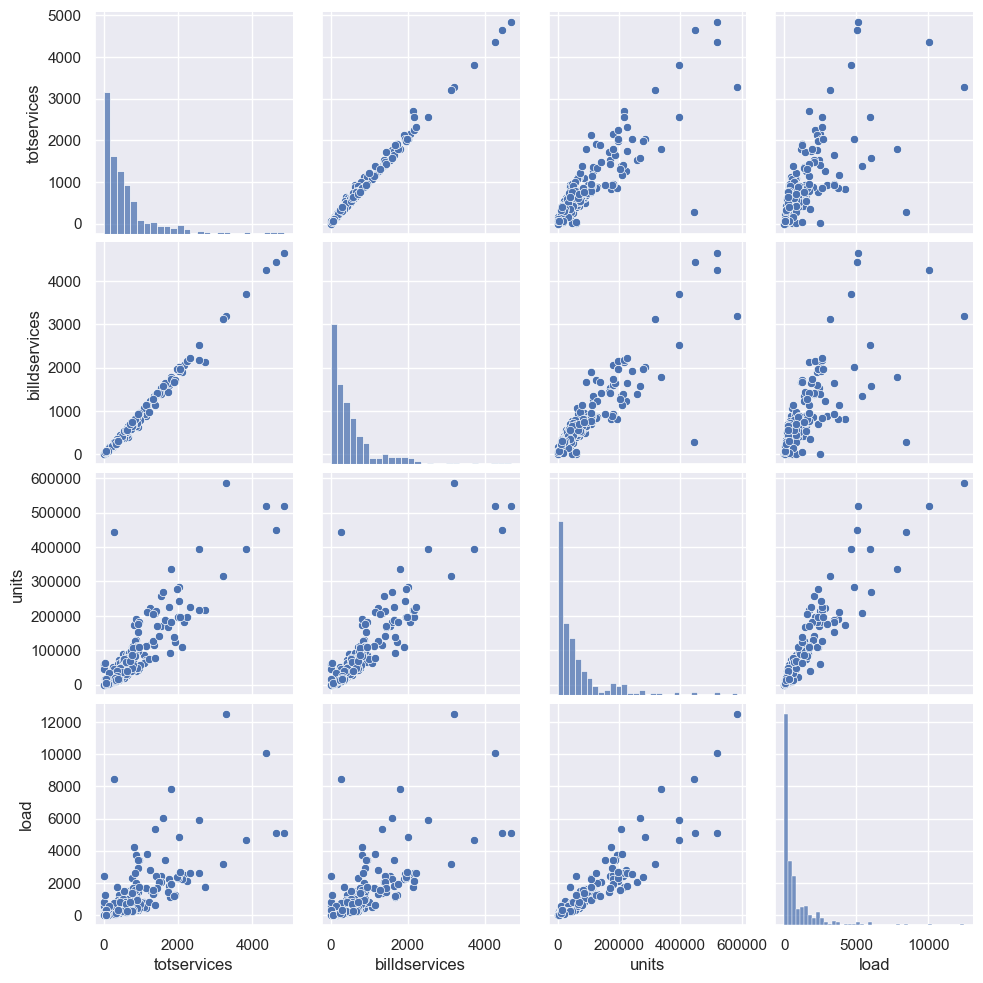

In [37]:
import seaborn as sns

sns.pairplot(df[num_cols].sample(300))
plt.show()


In [38]:
# PART 2 — Preprocessing Setup

features = ['circle','division','subdivision','section','area','catcode',
            'totservices','billdservices','units','load']

num_feats = ['totservices','billdservices','units','load']
cat_feats = ['circle','division','subdivision','section','area','catcode']

print("Feature Columns:", features)
print("Numeric Features:", num_feats)
print("Categorical Features:", cat_feats)


Feature Columns: ['circle', 'division', 'subdivision', 'section', 'area', 'catcode', 'totservices', 'billdservices', 'units', 'load']
Numeric Features: ['totservices', 'billdservices', 'units', 'load']
Categorical Features: ['circle', 'division', 'subdivision', 'section', 'area', 'catcode']


In [39]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric processing: handle missing values + scale
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical processing: fill missing + one-hot encode
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both into one preprocessor
preprocess = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])

print("Preprocessing pipeline created successfully!")




Preprocessing pipeline created successfully!


In [40]:
# Fit transform (just to see output size)
X_prepared = preprocess.fit_transform(df[features])

print("Original shape :", df[features].shape)
print("Transformed shape:", X_prepared.shape)


Original shape : (15746, 10)
Transformed shape: (15746, 14427)


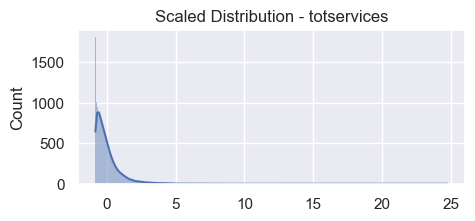

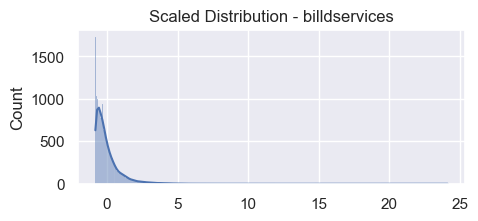

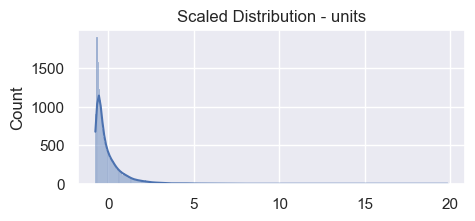

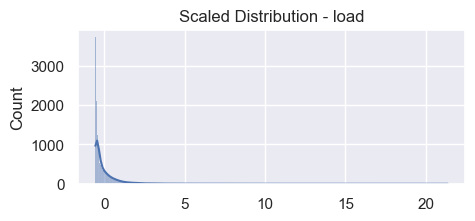

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract only scaled numeric columns for a quick visual check
scaled_num = preprocess.named_transformers_['num'].named_steps['scale'].transform(
                preprocess.named_transformers_['num'].named_steps['impute'].transform(
                    df[num_feats]
                )
             )

for i, col in enumerate(num_feats):
    plt.figure(figsize=(5,2))
    sns.histplot(scaled_num[:, i], kde=True)
    plt.title(f"Scaled Distribution - {col}")
    plt.show()


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target
le = LabelEncoder()
y = le.fit_transform(df[TARGET].astype(str))

# Feature matrix
X = df[features]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (12596, 10)
Test: (3150, 10)


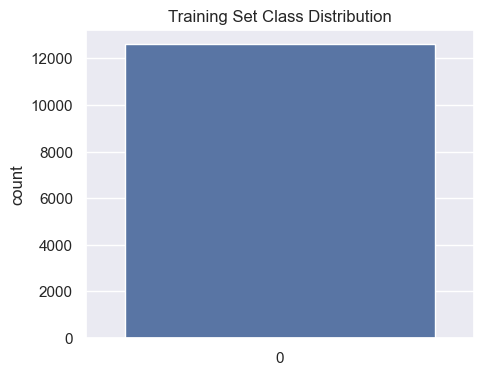

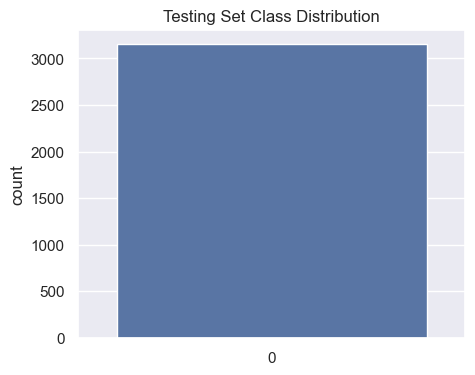

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title("Training Set Class Distribution")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x=y_test)
plt.title("Testing Set Class Distribution")
plt.show()


In [46]:
from sklearn.preprocessing import LabelEncoder

# FIXED TARGET (catdesc had only 1 class)
# NEW TARGET because catdesc has only one class
df['units_bin'] = pd.qcut(df['units'], q=4, labels=False, duplicates='drop')
TARGET = "units_bin"
print("Using new TARGET =", TARGET)
le = LabelEncoder()
y = le.fit_transform(df[TARGET])

print("Target classes:", list(le.classes_))


Using new TARGET = units_bin
Target classes: [0, 1, 2, 3]


In [47]:
X = df[features]   # features list from Part 2
print("Feature shape:", X.shape)


Feature shape: (15746, 10)


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train Shape: (12596, 10)
Test Shape: (3150, 10)


In [50]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print("Training label counts:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Testing label counts:", dict(zip(unique, counts)))


Training label counts: {0: 3192, 1: 3162, 2: 3113, 3: 3129}
Testing label counts: {0: 745, 1: 774, 2: 823, 3: 808}


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model
model_lr = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
model_lr.fit(X_train, y_train)

# Predict
y_pred = model_lr.predict(X_test)

# Results
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.9346031746031747

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       745
           1       0.89      0.90      0.89       774
           2       0.94      0.91      0.93       823
           3       0.98      0.97      0.98       808

    accuracy                           0.93      3150
   macro avg       0.93      0.93      0.93      3150
weighted avg       0.94      0.93      0.93      3150



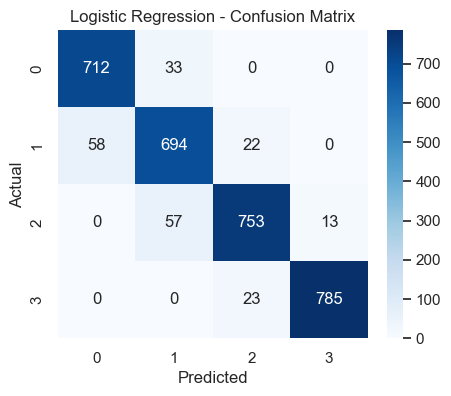

In [52]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_knn = Pipeline([
    ('preprocess', preprocess),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.8438095238095238

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       745
           1       0.73      0.82      0.77       774
           2       0.84      0.78      0.81       823
           3       0.96      0.92      0.94       808

    accuracy                           0.84      3150
   macro avg       0.85      0.84      0.84      3150
weighted avg       0.85      0.84      0.85      3150



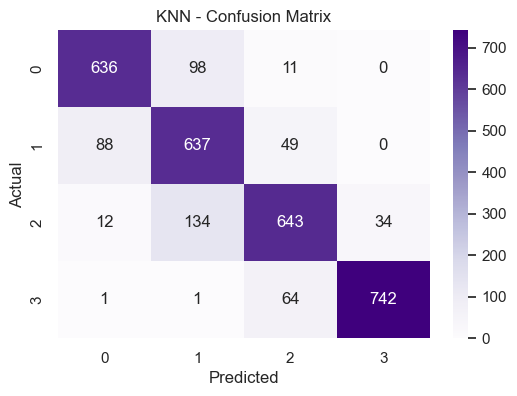

In [54]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Purples')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [55]:
# Decision Tree: train + metrics (no preprocessing repetition)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_dt = Pipeline([
    ('preprocess', preprocess),
    ('clf', DecisionTreeClassifier(max_depth=6, random_state=42))
])

# Train
model_dt.fit(X_train, y_train)

# Predict
y_pred_dt = model_dt.predict(X_test)

# Metrics
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.9996825396825397

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       745
           1       1.00      1.00      1.00       774
           2       1.00      1.00      1.00       823
           3       1.00      1.00      1.00       808

    accuracy                           1.00      3150
   macro avg       1.00      1.00      1.00      3150
weighted avg       1.00      1.00      1.00      3150



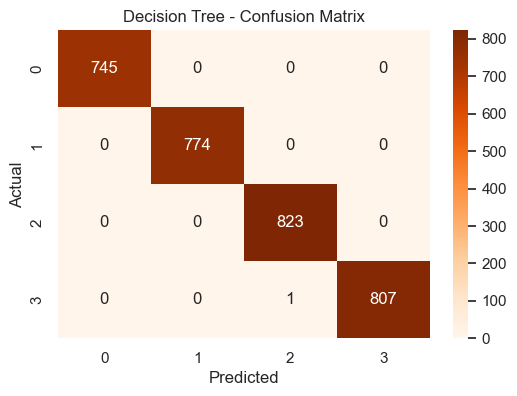

In [56]:
# Confusion matrix plot
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

In [57]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Collect model accuracies
accuracy_results = {
    "Logistic Regression": accuracy_score(y_test, y_pred),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Decision Tree": accuracy_score(y_test, y_pred_dt)
}

accuracy_df = pd.DataFrame.from_dict(accuracy_results, orient='index', columns=['Accuracy'])
print("\n=== Model Comparison ===")
display(accuracy_df)



=== Model Comparison ===


,Accuracy
Logistic Regression,0.934603
KNN,0.843810
Decision Tree,0.999683


In [58]:
num_cols = ['totservices', 'billdservices', 'units', 'load']


In [59]:
# Use numeric features only for unsupervised learning
unsup_features = num_cols  
X_unsup = df[unsup_features].fillna(df[unsup_features].median())

print("Unsupervised Data Shape:", X_unsup.shape)
display(X_unsup.head())


Unsupervised Data Shape: (15746, 4)


,totservices,billdservices,units,load
0,41,38.0,15982.0,541.26
1,589,585.0,118230.0,2256.60
2,33,23.0,10009.0,247.00
3,41,39.0,50108.0,756.00
4,652,597.0,140135.0,2882.12


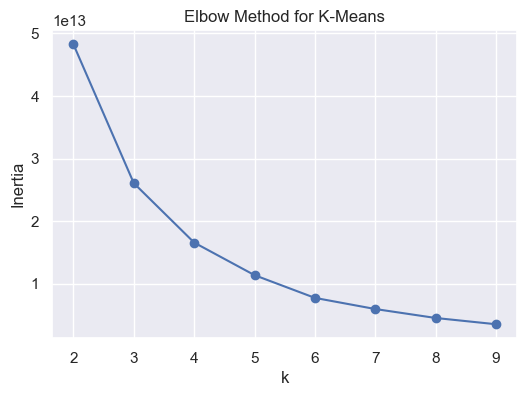

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_unsup)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()


In [61]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['KM_Cluster'] = kmeans.fit_predict(X_unsup)

print(df['KM_Cluster'].value_counts())


KM_Cluster
0    10746
1     3765
3     1055
2      180
Name: count, dtype: int64


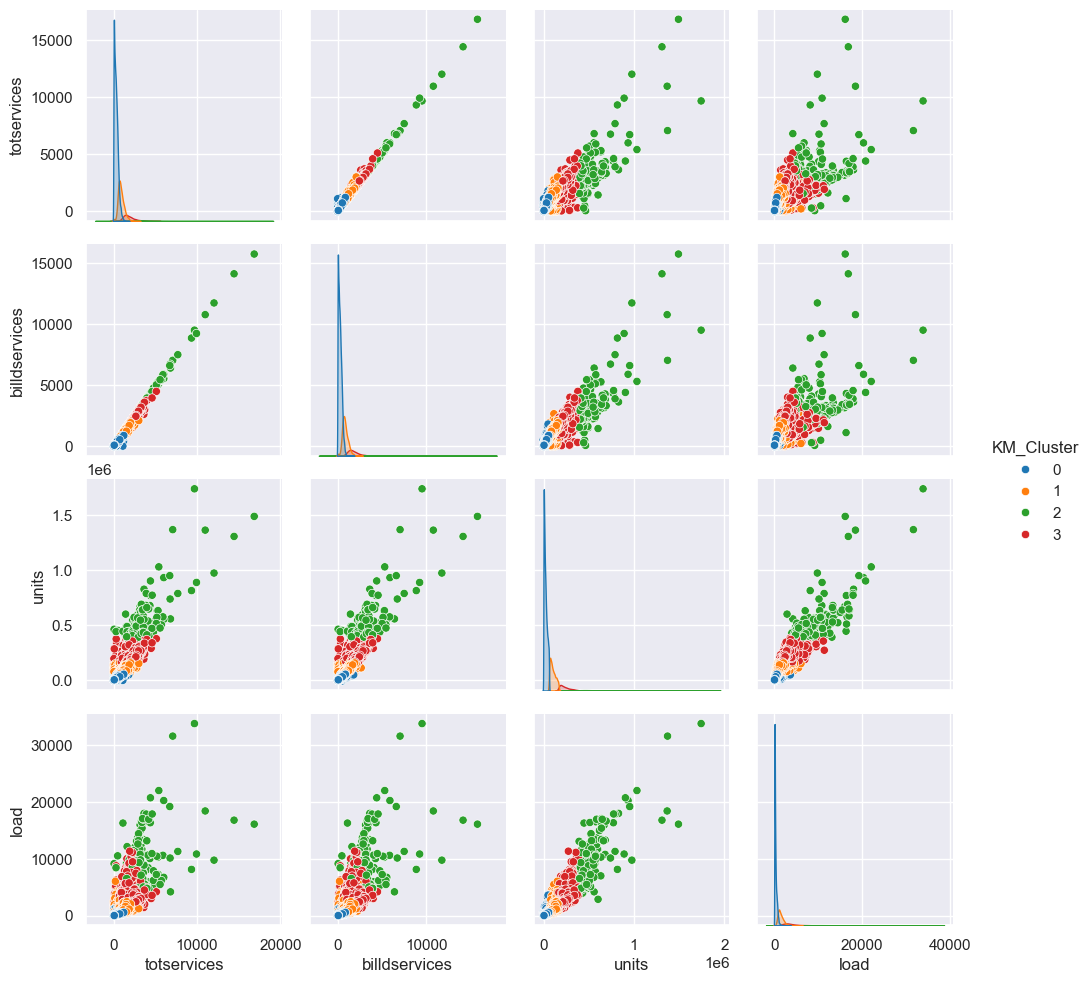

In [62]:
import seaborn as sns

sns.pairplot(df, vars=unsup_features, hue="KM_Cluster", palette="tab10")
plt.show()


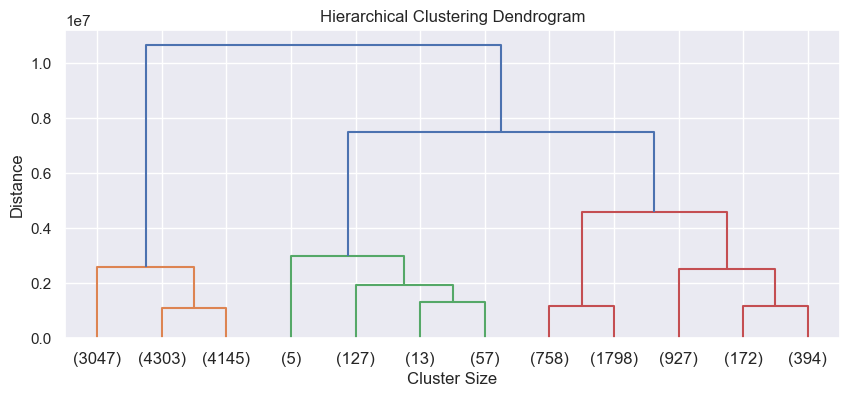

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
Z = linkage(X_unsup, method='ward')
dendrogram(Z, truncate_mode="lastp", p=12)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


In [64]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
df['AGG_Cluster'] = agg.fit_predict(X_unsup)

print(df['AGG_Cluster'].value_counts())


AGG_Cluster
1    11495
3     2556
2     1493
0      202
Name: count, dtype: int64


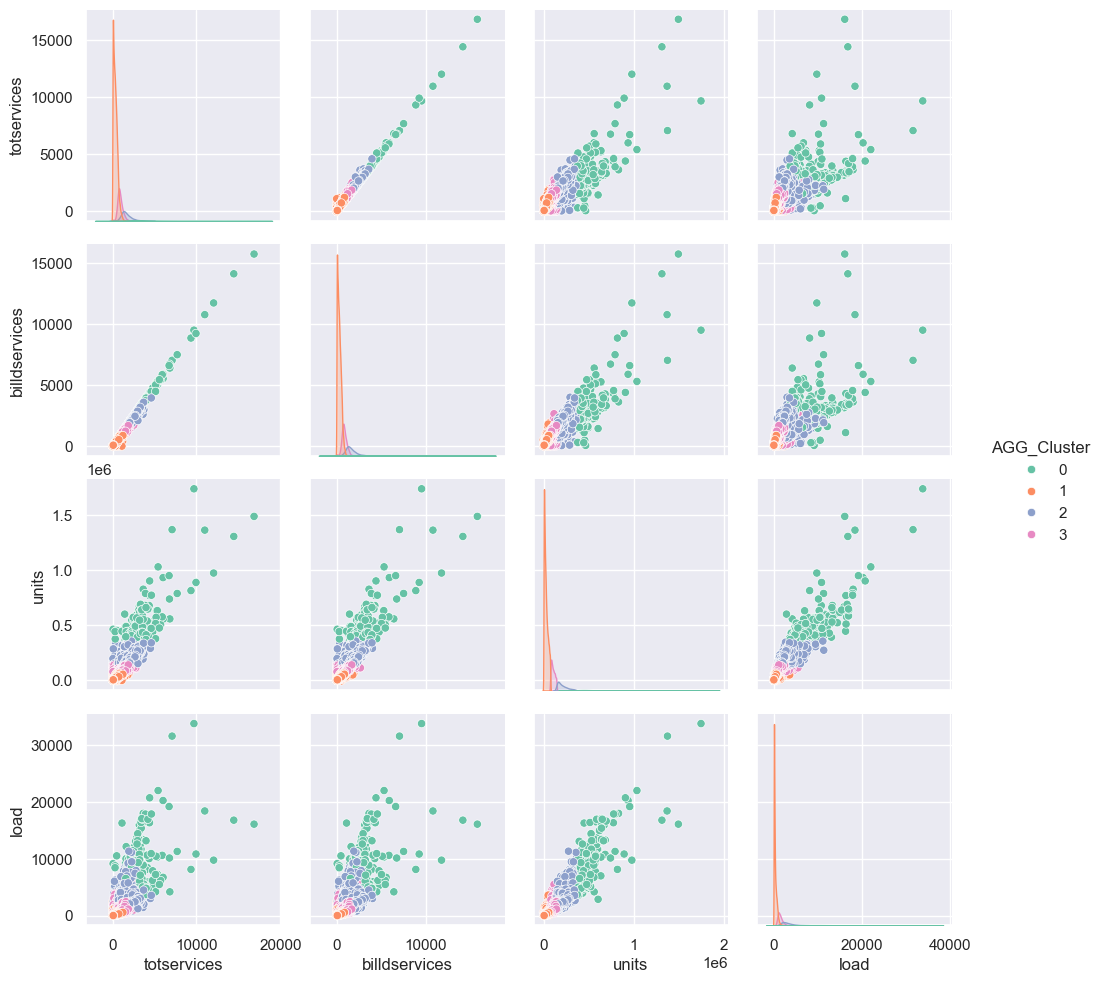

In [65]:
sns.pairplot(df, vars=unsup_features, hue="AGG_Cluster", palette="Set2")
plt.show()


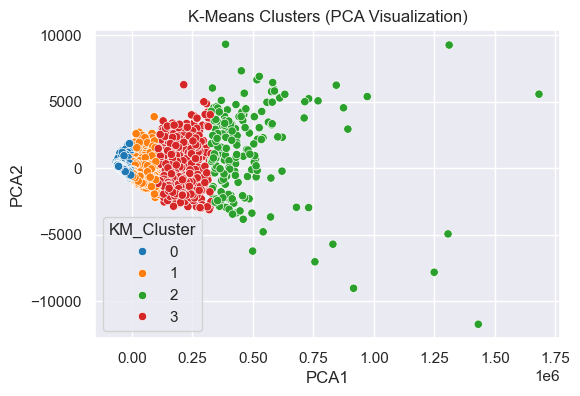

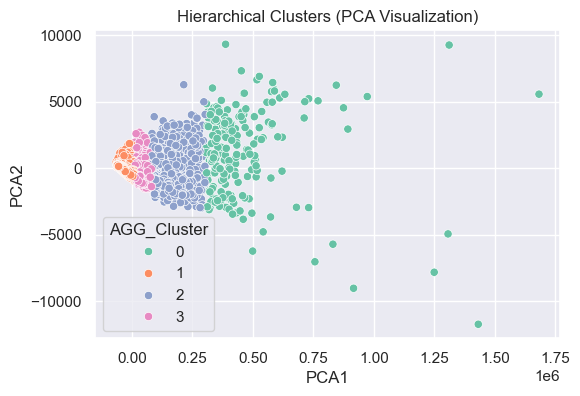

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_unsup)

df['PCA1'] = pca_data[:,0]
df['PCA2'] = pca_data[:,1]

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="KM_Cluster", palette="tab10")
plt.title("K-Means Clusters (PCA Visualization)")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="AGG_Cluster", palette="Set2")
plt.title("Hierarchical Clusters (PCA Visualization)")
plt.show()


In [67]:
import joblib

joblib.dump(model_lr, "Logistic_Regression_Model.pkl")
joblib.dump(model_knn, "KNN_Model.pkl")
joblib.dump(model_dt, "DecisionTree_Model.pkl")

print("Models saved successfully!")


Models saved successfully!
